In [1]:
import os, shutil
import random
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm, tqdm_notebook
import cv2
from scipy import stats
from sklearn.metrics import confusion_matrix, roc_curve,auc, classification_report, precision_score, recall_score
from sklearn.linear_model import LinearRegression

import skimage
import skimage.segmentation
import copy
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

import tensorflow as tf
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Flatten, Dense, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.imagenet_utils import decode_predictions

2.16.1


In [23]:
# Define paths for original datasets
original_dataset_parasitized = os.path.join('D:\Disease Prediction 2\BreastCancerDataset_1\8863', '1/')
original_dataset_uninfected = os.path.join('D:\Disease Prediction 2\BreastCancerDataset_1\8863', '0/')


In [24]:
# Create a base directory
base_dir = 'IDC_AND_NOIDC'
if not os.path.isdir(base_dir):
    os.mkdir(base_dir)

# Define train, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [25]:
# Create train, validation, and test directories if they don't exist
for dir_path in [train_dir, valid_dir, test_dir]:
    if not os.path.isdir(dir_path):
        os.mkdir(dir_path)

In [26]:
# Define infected and healthy directories within train, validation, and test
infected_trn_dir = os.path.join(train_dir, '1')
healthy_trn_dir = os.path.join(train_dir, '0')
infected_valid_dir = os.path.join(valid_dir, '1')
healthy_valid_dir = os.path.join(valid_dir, '0')
infected_test_dir = os.path.join(test_dir, '1')
healthy_test_dir = os.path.join(test_dir, '0')

In [27]:
# Create infected and healthy directories within train, validation, and test if they don't exist
for dir_path in [infected_trn_dir, healthy_trn_dir, infected_valid_dir, healthy_valid_dir, infected_test_dir, healthy_test_dir]:
    if not os.path.isdir(dir_path):
        os.mkdir(dir_path)

In [28]:
# Define the number of samples for training, validation, and test
num_train_infected = 400
num_train_healthy = 400
num_valid_infected = 20
num_valid_healthy = 20
num_test_infected = 120
num_test_healthy = 120

In [29]:
# Copy images to respective directories for training, validation, and test
def copy_images(source_dir, dest_dir, start_idx, end_idx):
    files = os.listdir(source_dir)
    fnames = files[start_idx:end_idx]
    for fname in fnames:
        src = os.path.join(source_dir, fname)
        dst = os.path.join(dest_dir, fname)
        shutil.copyfile(src, dst)

In [30]:
# Copy infected images for training, validation, and test
copy_images(original_dataset_parasitized, infected_trn_dir, 0, num_train_infected)
copy_images(original_dataset_parasitized, infected_valid_dir, num_train_infected, num_train_infected + num_valid_infected)
copy_images(original_dataset_parasitized, infected_test_dir, num_train_infected + num_valid_infected, num_train_infected + num_valid_infected + num_test_infected)

# Copy healthy images for training, validation, and test
copy_images(original_dataset_uninfected, healthy_trn_dir, 0, num_train_healthy)
copy_images(original_dataset_uninfected, healthy_valid_dir, num_train_healthy, num_train_healthy + num_valid_healthy)
copy_images(original_dataset_uninfected, healthy_test_dir, num_train_healthy + num_valid_healthy, num_train_healthy + num_valid_healthy + num_test_healthy)

In [31]:
# Print the number of images in each directory
print("{} Infected training images".format(len(os.listdir(infected_trn_dir))))
print("{} Uninfected training images".format(len(os.listdir(healthy_trn_dir))))
print("{} Infected validation images".format(len(os.listdir(infected_valid_dir))))
print("{} Uninfected validation images".format(len(os.listdir(healthy_valid_dir))))
print("{} Infected testing images".format(len(os.listdir(infected_test_dir))))
print("{} Uninfected testing images".format(len(os.listdir(healthy_test_dir))))

400 Infected training images
400 Uninfected training images
70 Infected validation images
70 Uninfected validation images
205 Infected testing images
210 Uninfected testing images


In [32]:
# Train
infected_trn_fpaths = [os.path.join(infected_trn_dir, fpath) for fpath in os.listdir(infected_trn_dir)]
healthy_trn_fpaths = [os.path.join(healthy_trn_dir, fpath) for fpath in os.listdir(healthy_trn_dir)]

# Valid
infected_valid_fpaths = [os.path.join(infected_valid_dir, fpath) for fpath in os.listdir(infected_valid_dir)]
healthy_valid_fpaths = [os.path.join(healthy_valid_dir, fpath) for fpath in os.listdir(healthy_valid_dir)]

# Test
infected_test_fpaths = [os.path.join(infected_test_dir, fpath) for fpath in os.listdir(infected_test_dir)]
healthy_test_fpaths = [os.path.join(healthy_test_dir, fpath) for fpath in os.listdir(healthy_test_dir)]

In [33]:
def get_img_shape(idx, img, total_num_images):
    
    if idx%2000 ==0 or idx == (total_num_images-1):
        print("working on img {}".format(idx))
    return cv2.imread(img).shape

data_inp = [(idx, img, len(infected_trn_fpaths + healthy_trn_fpaths)) for idx, img in enumerate(infected_trn_fpaths + healthy_trn_fpaths)]

train_img_dims_map = list(map(get_img_shape, [input[0] for input in data_inp],
    [input[1] for input in data_inp],
    [input[2] for input in data_inp]))

working on img 0
working on img 799


In [34]:
print('Min Dimensions:           {}'.format(np.min(train_img_dims_map, axis=0)))
print('Avg Dimensions:           {}'.format(np.mean(train_img_dims_map, axis=0)))
print('Median Dimensions:        {}'.format(np.median(train_img_dims_map, axis=0)))
print('Most Frequent Dimensions: {}'.format(stats.mode(train_img_dims_map, axis=0)[0]))
print('Max Dimensions:           {}'.format(np.max(train_img_dims_map, axis=0)))

Min Dimensions:           [35 50  3]
Avg Dimensions:           [49.94375 50.       3.     ]
Median Dimensions:        [50. 50.  3.]
Most Frequent Dimensions: [50 50  3]
Max Dimensions:           [50 50  3]


In [35]:
infected_trn_samples = random.sample(infected_trn_fpaths, 5)
healthy_trn_samples = random.sample(healthy_trn_fpaths, 5)

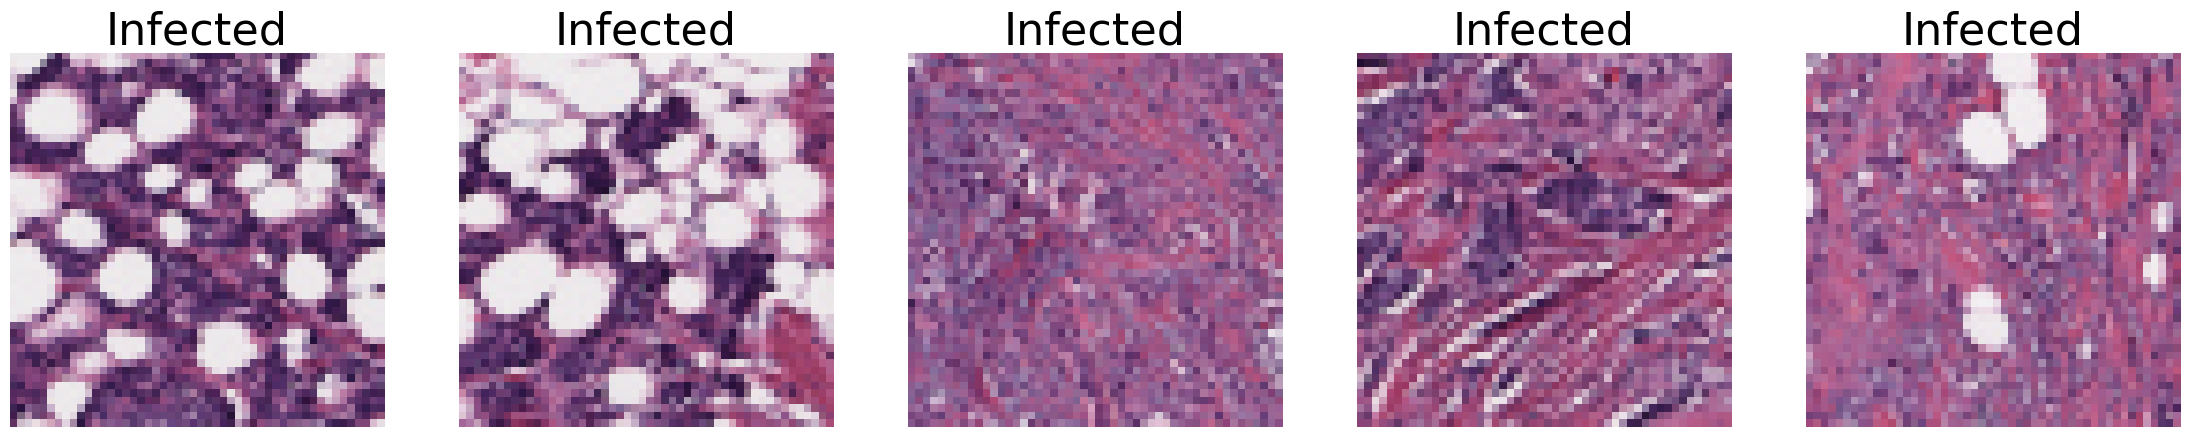

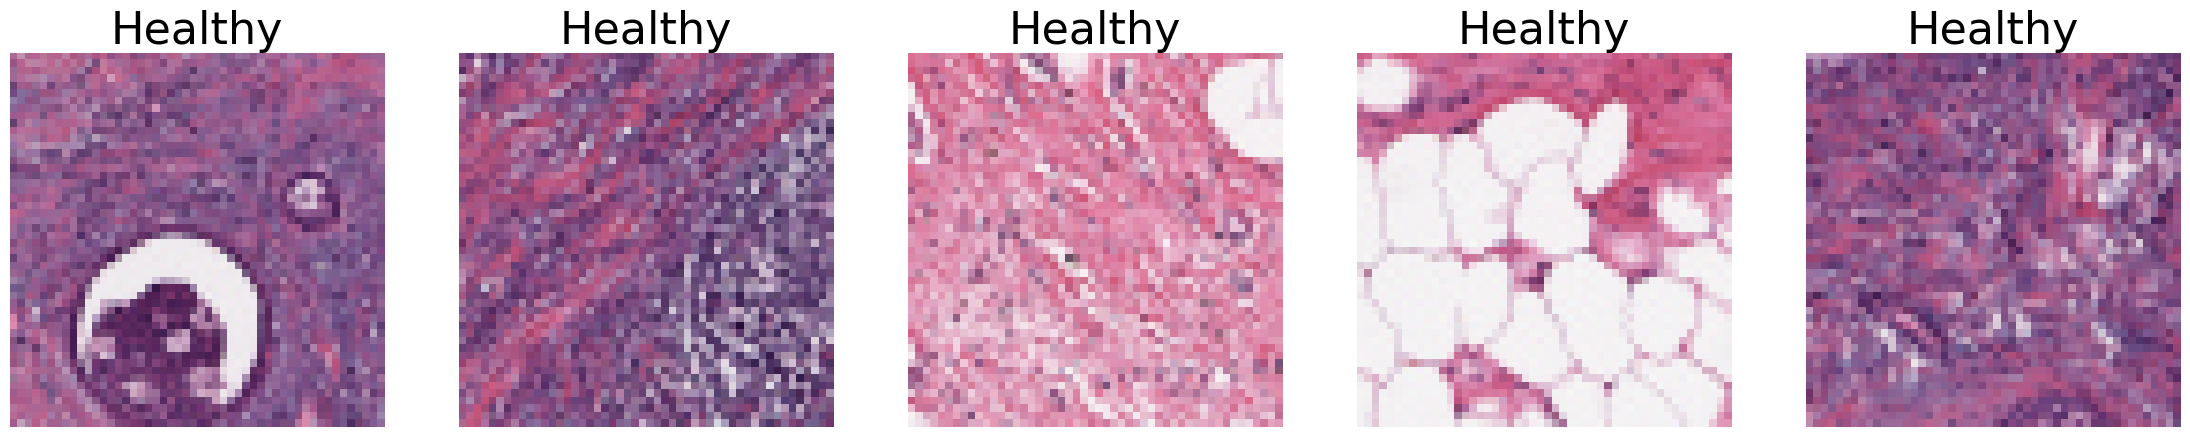

In [36]:
fig =plt.figure(figsize=(28,14))
columns=5
rows=1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mpimg.imread(infected_trn_samples[i-1]))
    plt.axis('off')
    plt.title('Infected', fontsize=32)
plt.show()


fig =plt.figure(figsize=(28,14))
columns=5
rows=1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mpimg.imread(healthy_trn_samples[i-1]))
    plt.axis('off')
    plt.title('Healthy', fontsize=32)
#plt.savefig("outputs/malaria_cell_images.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

In [37]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=0.4,
                                   vertical_flip=0.4,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=(128,128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    batch_size=32,
                                                    target_size=(128, 128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

class_labels = train_generator.class_indices
class_names = {value:key for (key, value) in class_labels.items()}

Found 800 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


In [38]:
class_labels, class_names

({'0': 0, '1': 1}, {0: '0', 1: '1'})

In [40]:
# Instantiate VGG19 model with weights from Imagenet without the calssifier at the top
# Build the network
base_model = VGG19(include_top=False, input_shape=(128,128,3))
x = base_model.output
flat=Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)
model_03 = Model(base_model.inputs, output)



sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# Compile the model
model_03.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Call backs
filepath = 'Model/breastcancer.keras'
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.0001)

# Define an optimizer
sgd = SGD(learning_rate=.0001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model_03.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

In [41]:
history_03 = model_03.fit(train_generator,
                          steps_per_epoch=100,
                          epochs=25,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/25


C:\Users\lloyd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 25/100 ━━━━━━━━━━━━━━━━━━━━ 5:08 4s/step - accuracy: 0.5189 - loss: 0.7421

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 0.51451, saving model to Model/breastcancer.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.5497 - loss: 0.6918 - val_accuracy: 0.7000 - val_loss: 0.5145 - learning_rate: 1.0000e-04
Epoch 2/25
 25/100 ━━━━━━━━━━━━━━━━━━━━ 5:03 4s/step - accuracy: 0.6540 - loss: 0.6244
Epoch 2: val_loss improved from 0.51451 to 0.36532, saving model to Model/breastcancer.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.6726 - loss: 0.5872 - val_accuracy: 0.8571 - val_loss: 0.3653 - learning_rate: 1.0000e-04
Epoch 3/25
 25/100 ━━━━━━━━━━━━━━━━━━━━ 5:11 4s/step - accuracy: 0.6864 - loss: 0.5852
Epoch 3: val_loss improved from 0.36532 to 0.29402, saving model to Model/breastcancer.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.7060 - loss: 0.5489 - val_accuracy: 0.9000 - val_loss: 0.2940 - learning_rate: 1.0000e-04
Epoch 4/25
 25/100 ━━━━━━━━━━━━━━━━━━━━ 5:16 4s/step - accuracy: 0.7650 - loss: 0.5097
Epoch 4: val_loss improve

In [42]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save_weights(filepath='model_weights/vgg19_model_01breastcancer.weights.h5', overwrite=True)

In [43]:
# Resize test images similar to the train data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(128, 128),
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  seed=42,
                                                  color_mode='rgb')

Found 415 images belonging to 2 classes.


In [44]:
# Load the saved model
model_03.load_weights('model_weights/vgg19_model_01breastcancer.weights.h5')
# Evaluate the model on the hold out validation and test datasets

# Evaluate the model on batches of validation and testing data
vgg_val_eval_01 = model_03.evaluate(valid_generator)
vgg_test_eval_01 = model_03.evaluate(test_generator)

print('Validation loss:     {0:.4f}'.format(vgg_val_eval_01[0]))
print('Validation accuracy: {0:.4f}'.format(vgg_val_eval_01[1]))
print('Test loss:           {0:.4f}'.format(vgg_test_eval_01[0]))
print('Test accuracy:       {0:.4f}'.format(vgg_test_eval_01[1]))

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 956ms/step - accuracy: 0.9219 - loss: 0.1971
415/415 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - accuracy: 0.8116 - loss: 0.3522
Validation loss:     0.1924
Validation accuracy: 0.9143
Test loss:           0.2098
Test accuracy:       0.8988


In [45]:
filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_01 = model_03.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_01= np.argmax(vgg_predictions_01, axis=1)

415/415 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step


In [46]:
# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_01, 
                            target_names=['healthy', 'infected']))
vgg_conf_mat_01 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_01), 
                        index=['healthy', 'infected'], 
                        columns=['healthy', 'infected'])

              precision    recall  f1-score   support

     healthy       0.95      0.84      0.89       210
    infected       0.86      0.96      0.90       205

    accuracy                           0.90       415
   macro avg       0.90      0.90      0.90       415
weighted avg       0.90      0.90      0.90       415



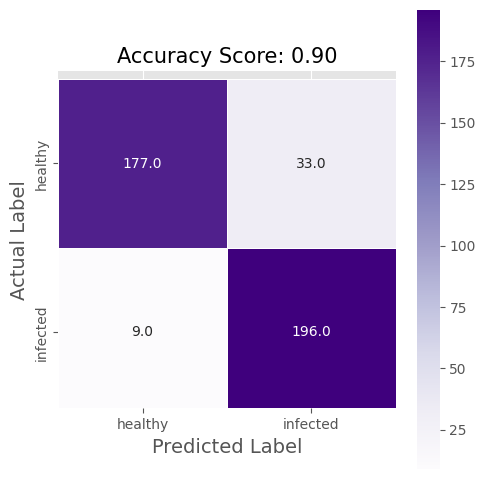

In [47]:
fig, ax = plt.subplots(figsize=(5,5))
#plt.figure(figsize=(9,9))
sns.heatmap(vgg_conf_mat_01, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_01[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_01)-0.05, -0.05)
plt.tight_layout()